In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv('./WheatData.csv')
dataset.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [3]:
#Key Attributes
dataset.describe()

,A,P,C,LK,WK,A_Coef,LKG,target
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000


In [4]:
#Create x and y variables
x = dataset.drop('target', axis=1).to_numpy()
y = dataset['target'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create Pipelines
pipe_dt = Pipeline([('sc', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=100))])
pipe_rdf = Pipeline([('sc', StandardScaler()), ('clf', RandomForestClassifier(random_state=100))])

# Fit the models (not necessary for plotting learning curves, but included for completeness)
pipe_dt.fit(x_train, y_train)
pipe_rdf.fit(x_train, y_train)


Pipeline(steps=[('sc', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=100))])

In [6]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Decision Tree - Learning Curve


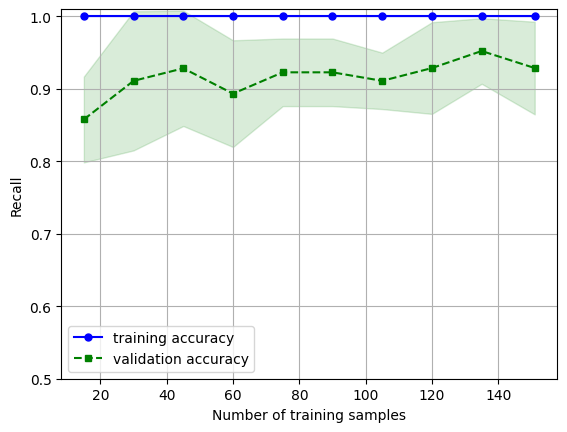


Random Forest - Learning Curve


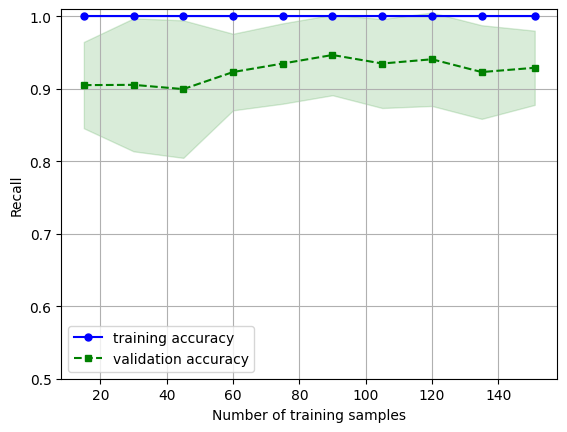

In [7]:
#Plot Learning Curve
print('Decision Tree - Learning Curve')
plot_learning_curves(pipe_dt)
print('\nRandom Forest - Learning Curve')
plot_learning_curves(pipe_rdf)

Model Evaluation - Recall
Decision Tree 0.94 +/- 0.05
Random Forest 0.93 +/- 0.05




C:\Users\Viththakan\AppData\Local\Temp\ipykernel_7052\1111877187.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names)


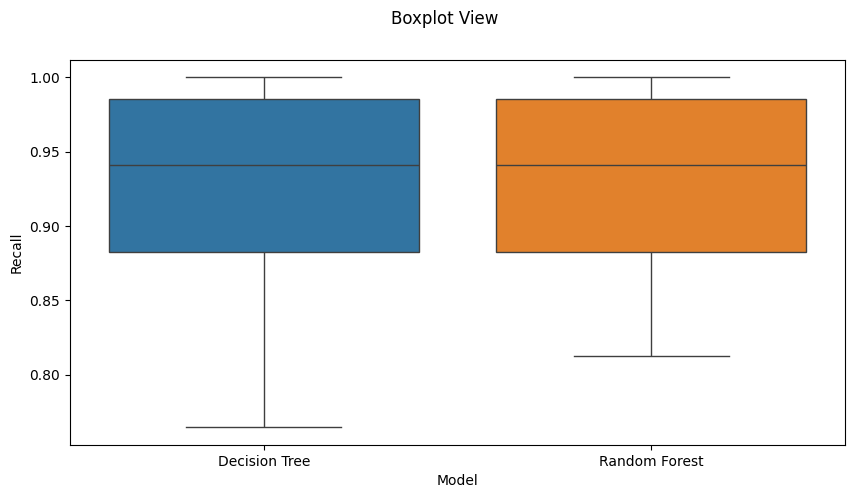

In [8]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Decision Tree',pipe_dt))
models.append(('Random Forest',pipe_rdf))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [9]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params,cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\n')
    
    #Feature Importance - optimized
    print('Feature Importances')
    for name, score in zip(list(dataset),gs_clf.best_estimator_.named_steps['clf'].feature_importances_):
        print(name, round(score,2))
    
    #Output Validation Statistics
    target_names=['setosa','versicolor','virginica']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names))     

In [10]:
# Define Gridsearch Function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    # Cross-validation Function
    cv2 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    
    # GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2, scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    best_model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = best_model.predict(x_test)

    # Identify Best Parameters to Optimize the Model
    best_params = gs_clf.best_params_
    
    # Output Heading
    print('\nOptimized Model')
    print('\nModel Name:', str(best_model.named_steps['clf']))
    print('\n')
    
    # Feature Importance - optimized (only for models that have this attribute)
    if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
        print('Feature Importances')
        for name, score in zip(dataset.drop('target', axis=1).columns, best_model.named_steps['clf'].feature_importances_):
            print(name, round(score, 2))
    
    # Output Validation Statistics
    target_names = ['class1', 'class2', 'class3']  # Update according to your dataset's target names
    print('\nBest Parameters:', best_params)
    print('\n', confusion_matrix(y_test, y_pred))  
    print('\n', classification_report(y_test, y_pred, target_names=target_names))     


In [11]:
# Define parameter grids
dt_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10]
}

rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10]
}

# Model parameter grids
modelpara = [dt_param_grid, rf_param_grid]


In [12]:
# Run Models
for model, param_grid in zip([pipe_dt, pipe_rdf], modelpara):
    Gridsearch_cv(model, param_grid)



Optimized Model

Model Name: DecisionTreeClassifier(random_state=100)


Feature Importances
A 0.34
P 0.02
C 0.0
LK 0.0
WK 0.03
A_Coef 0.06
LKG 0.55

Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}

 [[13  1  0]
 [ 2 12  0]
 [ 1  0 13]]

               precision    recall  f1-score   support

      class1       0.81      0.93      0.87        14
      class2       0.92      0.86      0.89        14
      class3       1.00      0.93      0.96        14

    accuracy                           0.90        42
   macro avg       0.91      0.90      0.91        42
weighted avg       0.91      0.90      0.91        42


Optimized Model

Model Name: RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=100)


Feature Importances
A 0.18
P 0.2
C 0.04
LK 0.14
WK 0.12
A_Coef 0.06
LKG 0.25

Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

 [[12  1  1]
 

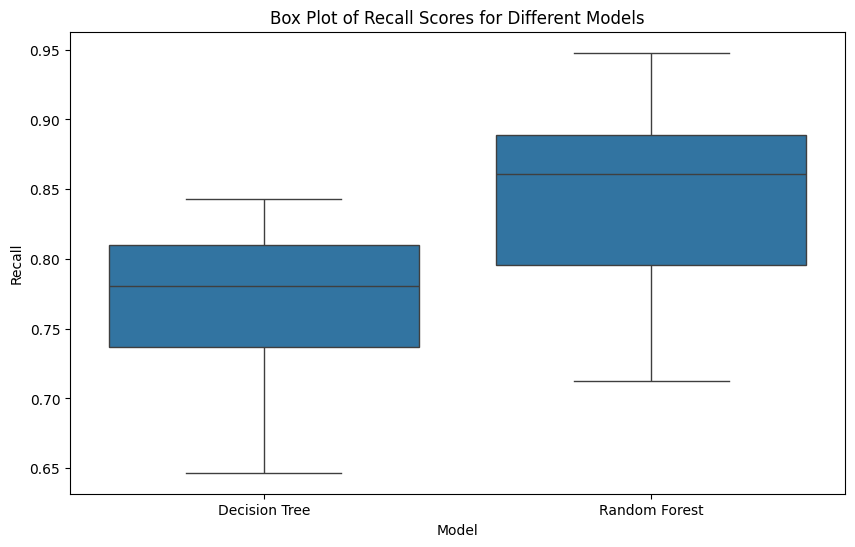


Decision Tree Statistics:
Q1: 0.7367458155283747
Q2 (Median): 0.7809130957980002
Q3: 0.8098955421054695
Min: 0.646770473705282
Max: 0.8428696416534955
IQR: 0.07314972657709484
Lower Whisker: 0.6270212256627324
Upper Whisker: 0.9196201319711118
Outliers: Series([], Name: Recall, dtype: float64)

Random Forest Statistics:
Q1: 0.7953453159160015
Q2 (Median): 0.8609964321496167
Q3: 0.8886095428863695
Min: 0.7122712423236308
Max: 0.9478507487122055
IQR: 0.09326422697036796
Lower Whisker: 0.6554489754604496
Upper Whisker: 1.0285058833419214
Outliers: Series([], Name: Recall, dtype: float64)


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
# Replace with actual data
data = {
    'Model': ['Decision Tree']*10 + ['Random Forest']*10,
    'Recall': np.concatenate([
        np.random.uniform(low=0.6, high=0.9, size=10),  # Random data for Decision Tree
        np.random.uniform(low=0.7, high=0.95, size=10)  # Random data for Random Forest
    ])
}
df = pd.DataFrame(data)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Recall', data=df)
plt.title('Box Plot of Recall Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.show()

# Extracting parameters
def extract_boxplot_stats(data):
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    min_val = np.min(data)
    max_val = np.max(data)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    outliers = data[(data < lower_whisker) | (data > upper_whisker)]
    
    return {
        'Q1': q1,
        'Q2 (Median)': q2,
        'Q3': q3,
        'Min': min_val,
        'Max': max_val,
        'IQR': iqr,
        'Lower Whisker': lower_whisker,
        'Upper Whisker': upper_whisker,
        'Outliers': outliers
    }

# Extract statistics for each model
models = df['Model'].unique()
stats = {}

for model in models:
    model_data = df[df['Model'] == model]['Recall']
    stats[model] = extract_boxplot_stats(model_data)

# Print statistics
for model, stat in stats.items():
    print(f'\n{model} Statistics:')
    for key, value in stat.items():
        if isinstance(value, np.ndarray):
            print(f'{key}: {value.tolist()}')
        else:
            print(f'{key}: {value}')
